# 1. Multi-class Classification
## 1.1 Dataset

In this exercise we will use machine learning (first logistic regression, and then a neural net) to recognize handwritten digits. We have a dataset of 5,000 handwritten digits (0-9) in 20 x 20 pixel grids. These grids have been flattened so that each example is a vector with 400 elements, each element representing the grayscale intensity of a particular pixel.

In [19]:
%matplotlib inline
%xmode plain

from math import sqrt

import scipy.io
import numpy as np
from numpy import log, sum # Overrides builtin sum()
from scipy.special import expit as sigmoid # expit is such a weird name
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# Load all variables defined in the matlab file into the local namespace
locals().update(scipy.io.loadmat('ex3data1.mat'))

display(X.shape)
y.shape

Exception reporting mode: Plain


(5000, 400)

(5000, 1)

## 1.2 Visualizing the data

Let's look at 100 randomly selected examples.

In [4]:
m, n = X.shape

# Choose 100 randomly selected examples
n_examples = 100
examples = X[np.random.permutation(m)][:n_examples]

# We'll display square images
image_width = round(sqrt(n))
image_height = round(n / image_width)
display((image_width, image_height))

# We'll also use a square grid of images
n_rows = round(sqrt(n_examples))
n_columns = round(n_examples / n_rows)
display((n_rows, n_columns))

(20, 20)

(10, 10)

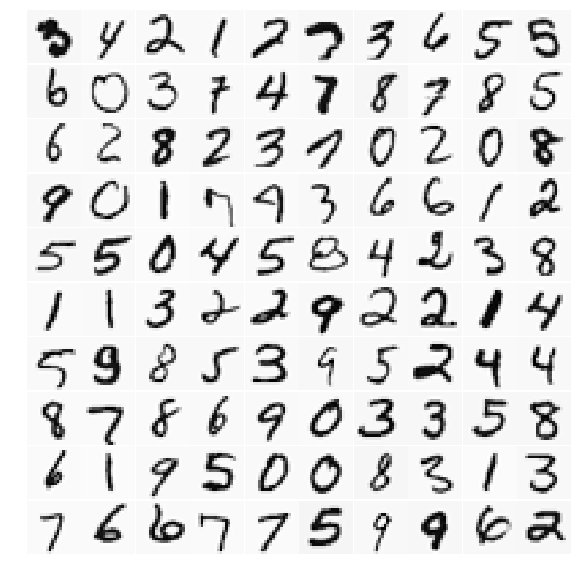

In [45]:
fig = plt.figure(1, (10, 10))
grid = ImageGrid(
    fig, 111,
    nrows_ncols=(n_rows, n_columns)
)

for i in range(n_examples):
    img = examples[i].reshape(image_width, image_height).transpose()
    grid[i].imshow(img, cmap='Greys')
    grid[i].axis('off')

## 1.3 Vectorizing logistic regression

### 1.3.1 Vectorizing the cost function
I'll re-use my implementation of the regularized logistic regression cost function from Exercise 2 since it was already vectorized.

In [5]:
def cost_function_reg(theta, X, y, _lambda):
    m, n = X.shape
    
    J = (1 / m) * sum(
        -y * log(sigmoid(X @ theta)) - 
        (1 - y) * log((1 - sigmoid(X @ theta)))
    ) + (_lambda / (2 * m)) * sum(theta[1:] ** 2)

    grad = (1 / m) * sum((sigmoid(X @ theta) - y) * X, axis=0).reshape(n, 1) + \
           (_lambda / m) * theta
    grad[0] = ((1 / m) * sum((sigmoid(X @ theta) - y) * X, axis=0))[0]
    return J, grad.flatten()

Define some test data.

In [6]:
theta_test = np.array([-2, -1, 1, 2]).reshape(-1, 1)

a = np.ones(5).reshape(-1, 1)
b = np.arange(1, 16).reshape(3, 5).transpose() / 10
X_test = np.concatenate((a, b), axis=1)
y_test = np.array([1, 0, 1, 0, 1]).reshape(-1, 1)
display(X_test)
y_test

array([[ 1. ,  0.1,  0.6,  1.1],
       [ 1. ,  0.2,  0.7,  1.2],
       [ 1. ,  0.3,  0.8,  1.3],
       [ 1. ,  0.4,  0.9,  1.4],
       [ 1. ,  0.5,  1. ,  1.5]])

array([[1],
       [0],
       [1],
       [0],
       [1]])

Verify that the regularized cost function works as expected.

In [7]:
J, grad = cost_function_reg(theta_test, X_test, y_test, 3)
print(f"Cost: {J:.03f}")
grad

Cost: 2.535


array([ 0.14656137, -0.54855841,  0.72472227,  1.39800296])

### 1.3.2 Vectorizing the gradient

This is taken care of by the above function.

### 1.3.3 Vectorizing regularized logistic regression
Likewise taken care of by the above function.

## 1.4 One-vs-all classification

To prepare for the classification, a couple tweaks to the data:

In [20]:
# Add bias to X
bias = np.ones(m).reshape(-1, 1)
X = np.concatenate((bias, X), axis=1)

# The labels are intentionally off-by-one to work with Octave's one-based array indices
y -= 1

Now we train a classifier for each digit.

In [78]:
from scipy.optimize import minimize

initial_theta = np.zeros(n + 1).reshape(n + 1, 1)

num_labels = 10
_lambda = 0.1
all_theta = np.ones((num_labels, n + 1))
for i in range(num_labels):
    print(f"Training classifier {i}")
    res = minimize(lambda theta: cost_function_reg(
        theta.reshape(n + 1, 1),
        X,
        np.where(y == i, 1, 0),
        _lambda
    ), initial_theta, jac=True, options={ 'maxiter': 100}) # 50 iterations only gets 93% accuracy
    all_theta[i, :] = res.x

Training classifier 0
Training classifier 1
Training classifier 2
Training classifier 3
Training classifier 4
Training classifier 5
Training classifier 6
Training classifier 7
Training classifier 8
Training classifier 9


### 1.4.1 One-vs-all prediction

In [79]:
A = X @ all_theta.T
predictions = A.argmax(axis=1).reshape(-1, 1) # Column vector to match y
print("Accuracy: {:.1%}".format(np.mean(predictions == y)))

Accuracy: 94.9%
